In [98]:
%reset -f

In [ ]:
!pip install torch


In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2

import math
import os

ImportError: No module named 'torch'

In [136]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")

In [208]:
class TrafficDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, test_train='train'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_name_dict = {
            "non-motorized_vehicle":0,
            "articulated_truck":1,
            "background":2,
            "bicycle":3,
            "bus":4,
            "car":5,
            "motorcycle":6,
            "pedestrian":7,
            "pickup_truck":8,
            "single_unit_truck":9,
            "work_van":10
        }
        self.test_train = test_train
        self.df = pd.read_csv(root_dir+csv_file, names=["name", "label_name"])
        self.df = self.add_label(self.df)
        self.root_dir = root_dir
        self.transform = transform
    
    def add_label(self, df):
        label = list()
        namelist = df["label_name"]
        for i, item in enumerate(namelist):
            if item in self.label_name_dict.keys():
                label.append(self.label_name_dict[item])
            else:
                label.append("Nan")
        df["label"] = label
        return df
    
    def get_name_string(self, idx):
        string = str(self.df.iloc[idx, 0])
        
        if len(string) < 8:
            diff = 8-len(string)
            for i in range(diff):
                string = '0'+string
        return string
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        namestring = self.get_name_string(idx)
        
        if self.test_train == 'train':
            img_name = os.path.join(self.root_dir,'data',self.test_train, str(self.df.iloc[idx, 1]), namestring +'.jpg')
        else:
            img_name = os.path.join(self.root_dir,'data',self.test_train, namestring+'.jpg')
        
        image = cv2.imread(img_name)
        #print('Before scale {}'.format(image))
        image = image/255
        #print('After scale {}'.format(image))
#         print("image is type {}".format(type(image)))
#         print("image is shape {}".format(np.shape(image)))
        #image = io.imread(img_name)
        label = self.df.iloc[idx, 2:]
        label = int(label)
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [244]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size = 256):
        self.output_size = output_size

    def __call__(self, sample):
#         plt.imshow(sample['image'])
#         print(sample['label'])
        image, label = sample['image'], sample['label']
        image = cv2.resize(image, (self.output_size, self.output_size))
        
#         plt.imshow(sample['image'])
#         print(sample['label'])
        return {'image': image, 'label': label}

In [245]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
#         #plt.imshow(sample['image'])
#         print(sample['label'])
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        
#         print("image is type {}".format(type(image)))
#         print("image is shape {}".format(np.shape(image)))
#         plt.imshow(image)
        
        image = image.transpose((2, 0, 1))
        
        #print("image is shape {}".format(np.shape(image)))
        
#         plt.imshow(sample['image'])
#         print(sample['label'])
        return {'image': torch.from_numpy(image),
                'label': torch.tensor(label)}

In [246]:
data = TrafficDataset(csv_file ='\data\gt_train.csv', root_dir = os.getcwd(), transform=transforms.Compose([Rescale(256),ToTensor()]), test_train='train')

#transforms.Compose([Rescale(120),ToTensor()])
train_dataset, test_dataset = torch.utils.data.random_split(data, [len(data) - 50000, 50000])

#print(train_dataset.__getitem__(0))


In [247]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
    #num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True
    #num_workers=4
)

In [248]:
for i, item in enumerate(train_loader):
    print(i, print(item['image']))
    break

tensor([[[[0.1529, 0.1529, 0.1529,  ..., 0.2039, 0.2039, 0.2039],
          [0.1529, 0.1529, 0.1529,  ..., 0.2039, 0.2039, 0.2039],
          [0.1529, 0.1529, 0.1529,  ..., 0.2039, 0.2039, 0.2039],
          ...,
          [0.2118, 0.2118, 0.2118,  ..., 0.1333, 0.1333, 0.1333],
          [0.2118, 0.2118, 0.2118,  ..., 0.1333, 0.1333, 0.1333],
          [0.2118, 0.2118, 0.2118,  ..., 0.1333, 0.1333, 0.1333]],

         [[0.2588, 0.2588, 0.2588,  ..., 0.3098, 0.3098, 0.3098],
          [0.2588, 0.2588, 0.2588,  ..., 0.3098, 0.3098, 0.3098],
          [0.2588, 0.2588, 0.2588,  ..., 0.3098, 0.3098, 0.3098],
          ...,
          [0.3176, 0.3176, 0.3176,  ..., 0.1529, 0.1529, 0.1529],
          [0.3176, 0.3176, 0.3176,  ..., 0.1529, 0.1529, 0.1529],
          [0.3176, 0.3176, 0.3176,  ..., 0.1529, 0.1529, 0.1529]],

         [[0.2431, 0.2431, 0.2431,  ..., 0.2941, 0.2941, 0.2941],
          [0.2431, 0.2431, 0.2431,  ..., 0.2941, 0.2941, 0.2941],
          [0.2431, 0.2431, 0.2431,  ..., 0

In [265]:
model = models.alexnet(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False
    
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 11)


model = model.float()

In [266]:
NUM_EPOCHS = 10
BEST_MODEL_PATH = os.path.join('bestmodels','traffic','best_model.pth')
best_accuracy = 0.0

optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    
    print("Starting Train Loader...")
    model.train()
    for i, item in enumerate(train_loader):
        if i % 1000 == 0:
            print(i)
        images = item['image'].to(device)
        labels = item['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print("Starting Test Loader...")
    model.eval()
    test_error_count = 0.0
    for i, item in enumerate(test_loader):
        if i % 1000 == 0:
            print(i)
        images = item['image'].to(device)
        labels = item['label'].to(device)
        outputs = model(images.float())
        test_error_count += float(torch.sum(torch.abs(labels - outputs.argmax(1))))
    
    test_accuracy = 1.0 - float(test_error_count) / float(len(test_dataset))
    print('Epoch {}: Accuracy: {:.3f}'.format(epoch, test_accuracy))
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_accuracy = test_accuracy

Starting Train Loader...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
Starting Test Loader...
0
1000
2000
3000
Epoch 0: Accuracy: 0.718
Starting Train Loader...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
Starting Test Loader...
0
1000
2000
3000
Epoch 1: Accuracy: 0.752
Starting Train Loader...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
Starting Test Loader...
0
1000
2000
3000
Epoch 2: Accuracy: 0.783
Starting Train Loader...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
Starting Test Loader...
0
1000
200

KeyboardInterrupt: 

In [262]:
BEST_MODEL_PATH = os.path.join('bestmodels','traffic','best_model.pth')

print(BEST_MODEL_PATH)
torch.save(model.state_dict(), BEST_MODEL_PATH)

bestmodels\traffic\best_model.pth


Labels: tensor([ 8,  5,  5,  5,  5, 10,  5,  5,  5,  2,  2,  2,  5,  2,  8, 10])
Outputs: tensor([ 8,  5,  5,  5,  5, 10,  5,  5,  5,  2,  2,  2,  5,  2,  8,  5])


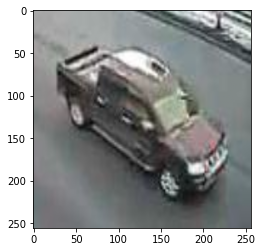

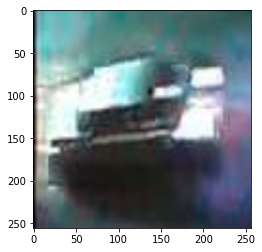

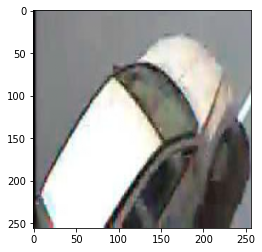

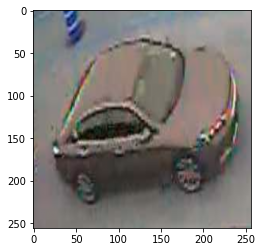

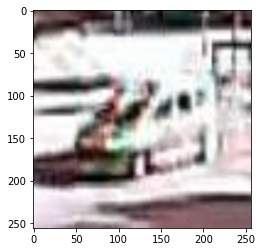

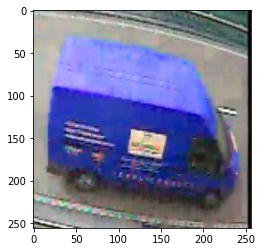

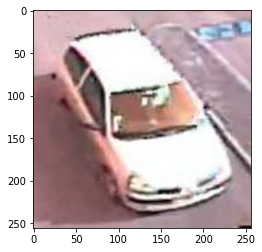

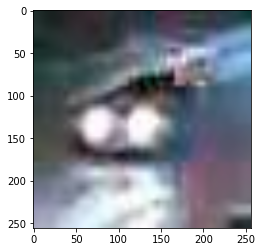

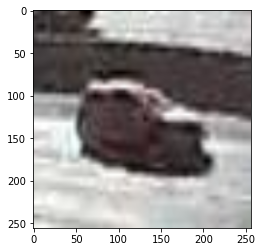

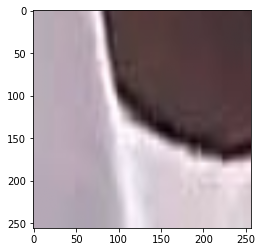

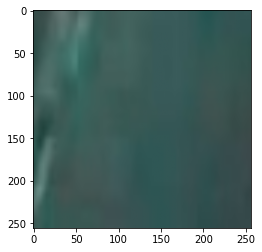

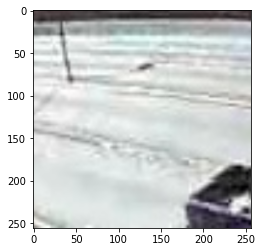

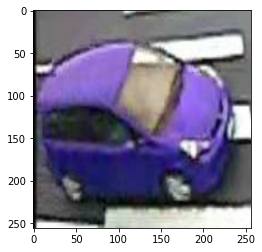

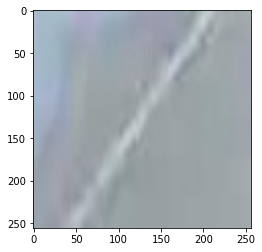

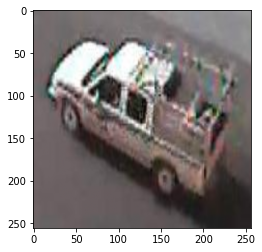

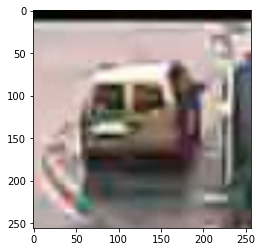

In [271]:
for i, item in enumerate(test_loader):
    images = item['image'].to(device)
    labels = item['label'].to(device)
    outputs = model(images.float())
    print("Labels: {}".format(labels))
    print("Outputs: {}".format(outputs.argmax(1)))
    for image in images:
        #label = model(image.float())
        #print("Label: {}".format(label))
        image = image.detach().cpu().numpy()
        #print(type(image))
        image = image.transpose((1, 2, 0))
        #print(np.shape(image))
        plt.figure()
        plt.imshow(image)
    plt.show()
    break
#     print("Guess: {}".format(outputs.argmax(1)))
#     print("Label: {}".format(labels))

In [242]:
print('Epoch {}: Accuracy: {:.3f}'.format(epoch, test_accuracy))

Epoch 1: Accuracy: 0.806


In [1]:
import cv2
  
  
# define a video capture object
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, image = vid.read()
    
    image = cv2.resize(image, (256,256))
    image = image.transpose((2, 0, 1))
    
    imaget = torch.from_numpy(image)
    imaget = imaget.unsqueeze(0)
    print(imaget.size())
    imaget = imaget.to(device)
    
    label = model(imaget.float())
    break
    # Display the resulting frame
    cv2.imshow('frame', image)
    
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
plt.imshow(image)
        
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

ImportError: No module named 'cv2'